In [1]:
# Add / Run this cell first to fix the issue with environment variables for Java not being set properly
# Even though they're in .bash_profile
# TODO: Fix this

%run '../../spark_variables.ipynb'

In [2]:
#Initialize and load weather dataframe

from pyspark import SparkContext
sc = SparkContext(master="local[4]")
#sc.version

import os
import sys

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType
%pylab inline

# Just like using Spark requires having a SparkContext, using SQL requires an SQLContext
sqlContext = SQLContext(sc)

from os.path import split,join,exists
from os import mkdir,getcwd,remove
from glob import glob

# create directory if needed

notebook_dir=getcwd()
data_dir=join(split(split(notebook_dir)[0])[0],'Data')
weather_dir=join(data_dir,'Weather')

if exists(weather_dir):
    print('directory',weather_dir,'already exists')
else:
    print('making',weather_dir)
    mkdir(weather_dir)

file_index='NY'
zip_file='%s.tgz'%(file_index) #the .csv extension is a mistake, this is a pickle file, not a csv file.
old_files='%s/%s*'%(weather_dir,zip_file[:-3])
for f in glob(old_files):
    print('removing',f)
    !rm -rf {f}

command="wget https://mas-dse-open.s3.amazonaws.com/Weather/by_state/%s -P %s "%(zip_file, weather_dir)
print(command)
!$command
!ls -lh $weather_dir/$zip_file

#extracting the parquet file
!tar zxvf {weather_dir}/{zip_file} -C {weather_dir}

weather_parquet = join(weather_dir,zip_file[:-3]+'parquet')
print(weather_parquet)
df = sqlContext.read.load(weather_parquet)
df.show(1)

Populating the interactive namespace from numpy and matplotlib
directory /Users/brianroepke/Projects/UCSanDiegoX/Big-Data/Data/Weather already exists
removing /Users/brianroepke/Projects/UCSanDiegoX/Big-Data/Data/Weather/NY.tgz
removing /Users/brianroepke/Projects/UCSanDiegoX/Big-Data/Data/Weather/NY.parquet
wget https://mas-dse-open.s3.amazonaws.com/Weather/by_state/NY.tgz -P /Users/brianroepke/Projects/UCSanDiegoX/Big-Data/Data/Weather 
--2019-09-16 06:05:11--  https://mas-dse-open.s3.amazonaws.com/Weather/by_state/NY.tgz
Resolving mas-dse-open.s3.amazonaws.com... 52.218.232.154
Connecting to mas-dse-open.s3.amazonaws.com|52.218.232.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66288146 (63M) [application/x-tar]
Saving to: '/Users/brianroepke/Projects/UCSanDiegoX/Big-Data/Data/Weather/NY.tgz'

NY.tgz              100%[===================>]  63.22M  35.9MB/s    in 1.8s    

2019-09-16 06:05:13 (35.9 MB/s) - '/Users/brianroepke/Projects/UCSanDiegoX/Big-D

## Dataframe operations
Spark DataFrames allow operations similar to pandas Dataframes. We demonstrate some of those.

For more, see the [official guide](https://spark.apache.org/docs/latest/sql-programming-guide.html) and [this article](https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/)

In [3]:
df.printSchema()

root
 |-- Station: string (nullable = true)
 |-- Measurement: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Values: binary (nullable = true)
 |-- dist_coast: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- elevation: double (nullable = true)
 |-- state: string (nullable = true)
 |-- name: string (nullable = true)



In [4]:
print(df.count())
df.show(1)

168398
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
only showing top 1 row



### .describe()
The method `df.describe()` computes five statistics for each column of the dataframe `df`.

The statistics are: **count, mean, std, min,max**

You get the following man page using the command `df.describe?`

```
Signature: df.describe(*cols)
Docstring:
Computes statistics for numeric and string columns.

This include count, mean, stddev, min, and max. If no columns are
given, this function computes statistics for all numerical or string columns.

.. note:: This function is meant for exploratory data analysis, as we make no
    guarantee about the backward compatibility of the schema of the resulting DataFrame.

>>> df.describe(['age']).show()
+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|                 2|
|   mean|               3.5|
| stddev|2.1213203435596424|
|    min|                 2|
|    max|                 5|
+-------+------------------+
>>> df.describe().show()
+-------+------------------+-----+
|summary|               age| name|
+-------+------------------+-----+
|  count|                 2|    2|
|   mean|               3.5| null|
| stddev|2.1213203435596424| null|
|    min|                 2|Alice|
|    max|                 5|  Bob|
+-------+------------------+-----+

.. versionadded:: 1.3.1
File:      ~/spark-2.2.1-bin-hadoop2.7/python/pyspark/sql/dataframe.py
Type:      method
```

In [5]:
df.describe().select('station','measurement').show()

+-----------+-----------+
|    station|measurement|
+-----------+-----------+
|     168398|     168398|
|       null|       null|
|       null|       null|
|USC00300015|       PRCP|
|USW00094794|   TOBS_s20|
+-----------+-----------+



#### groupby and agg
The method `.groupby(col)` groups rows according the value of the column `col`.  
The method `.agg(spec)` computes a summary for each group as specified in `spec`

In [6]:
df.groupby('measurement').agg({'year': 'min', 'station':'count'}).show()

+-----------+---------+--------------+
|measurement|min(year)|count(station)|
+-----------+---------+--------------+
|   TMIN_s20|     1873|         13442|
|       TMIN|     1873|         13442|
|   SNOW_s20|     1884|         15629|
|       TOBS|     1876|         10956|
|   SNWD_s20|     1888|         14617|
|   PRCP_s20|     1871|         16118|
|   TOBS_s20|     1876|         10956|
|       TMAX|     1873|         13437|
|       SNOW|     1884|         15629|
|   TMAX_s20|     1873|         13437|
|       SNWD|     1888|         14617|
|       PRCP|     1871|         16118|
+-----------+---------+--------------+



In [ ]:
# THis command will load the python module that defines the SQL functions
#%load ls ~/spark-latest/python/pyspark/sql/functions.py

### Using SQL queries on DataFrames

There are two main ways to manipulate  DataFrames:

#### Imperative manipulation
Using python methods such as `.select` and `.groupby`.
* Advantage: order of operations is specified.
* Disrdavantage : You need to describe both **what** is the result you want and **how** to get it.

#### Declarative Manipulation (SQL)
* Advantage: You need to describe only **what** is the result you want.
* Disadvantage: SQL does not have primitives for common analysis operations such as **covariance**

### Using sql commands on a dataframe
Spark supports a [subset](https://spark.apache.org/docs/latest/sql-programming-guide.html#supported-hive-features) of the Hive SQL query language.

For example, You can use [Hive `select` syntax](https://cwiki.apache.org/confluence/display/Hive/LanguageManual+Select) to select a subset of the rows in a dataframe.

To use sql on a dataframe you need to first `register` it as a `TempTable`.

for variety, we are using here a small dataframe loaded from a JSON file.

In [7]:
# when loading json files you can specify either a single file or a directory containing many json files.
path = "../../Data/people.json"

# Create a DataFrame from the file(s) pointed to by path
people = sqlContext.read.json(path)
#print('people is a',type(people))
# The inferred schema can be visualized using the printSchema() method.
people.show()

+----+-------+
| age|   name|
+----+-------+
|null|Michael|
|  30|   Andy|
|  19| Justin|
+----+-------+



In [8]:
people.printSchema()

root
 |-- age: long (nullable = true)
 |-- name: string (nullable = true)



In [9]:
# Register this DataFrame as a table.
people.registerTempTable("people")

# SQL statements can be run by using the sql methods provided by sqlContext
teenagers = sqlContext.sql("SELECT name FROM people WHERE age >= 13 AND age <= 19")
for each in teenagers.collect():
    print(each[0])

Justin


#### Counting the number of occurances of each measurement, imparatively

In [10]:
L=df.groupBy('measurement').count().collect()
#L is a list (collected DataFrame)

In [11]:
D=[(e.measurement,e['count']) for e in L]
sorted(D,key=lambda x:x[1], reverse=False)[:6]

[('TOBS', 10956),
 ('TOBS_s20', 10956),
 ('TMAX', 13437),
 ('TMAX_s20', 13437),
 ('TMIN_s20', 13442),
 ('TMIN', 13442)]

#### Counting the number of occurances of each measurement, declaratively.

In [12]:
sqlContext.registerDataFrameAsTable(df,'weather') #using older sqlContext instead of newer (V2.0) sparkSession

In [13]:
query="""
SELECT measurement,COUNT(measurement) AS count,
                   MIN(year) AS MinYear 
FROM weather  
GROUP BY measurement 
ORDER BY count
"""
print(query)
sqlContext.sql(query).show()


SELECT measurement,COUNT(measurement) AS count,
                   MIN(year) AS MinYear 
FROM weather  
GROUP BY measurement 
ORDER BY count

+-----------+-----+-------+
|measurement|count|MinYear|
+-----------+-----+-------+
|   TOBS_s20|10956|   1876|
|       TOBS|10956|   1876|
|       TMAX|13437|   1873|
|   TMAX_s20|13437|   1873|
|   TMIN_s20|13442|   1873|
|       TMIN|13442|   1873|
|   SNWD_s20|14617|   1888|
|       SNWD|14617|   1888|
|   SNOW_s20|15629|   1884|
|       SNOW|15629|   1884|
|   PRCP_s20|16118|   1871|
|       PRCP|16118|   1871|
+-----------+-----+-------+



#### Performing a map command
* In order to perform a `map` on a dataframe, you first need to transform it into an RDD.

* **Not** the recommended way. Better way is to use built-in sparkSQL functions.
* Or register new ones (Advanced).

In [14]:
def find_century(row):
    if row.Year < 1900:
        return '19th'
    elif row.Year <2000:
        return '20th'
    elif row.Year <2010:
        return '21st'
    else:
        return 'possibly_bad_data'

In [15]:
df.rdd.map(find_century).take(5)

['20th', '20th', '20th', '20th', '20th']

#### Aggregations 
* **Aggregation** can be used, in combination with built-in sparkSQL functions 
to compute statistics of a dataframe.
* computation will be fast thanks to combined optimzations with database operations.

* A partial list : `count(), approx_count_distinct(), avg(), max(), min()`

* Of these, the interesting one is `approx_count_distinct()` which uses sampling to get an approximate count fast.

* [The gory details](http://spark.apache.org/docs/2.2.0/api/python/_modules/pyspark/sql/functions.html)

In [16]:
import pyspark.sql.functions as F # used here just for show.

In [17]:
df.agg({'station':'approx_count_distinct'}).show()

+------------------------------+
|approx_count_distinct(station)|
+------------------------------+
|                           339|
+------------------------------+



#### Approximate Quantile

* Suppose we want to partition the years into 10 ranges
* such that in each range we have approximately the same number of records.
* The method `.approxQuantile` will use a sample to do this for us.

In [18]:
print('with accuracy 0.1: ',df.approxQuantile('year', [0.1*i for i in range(1,10)], 0.1))
print('with accuracy 0.01: ',df.approxQuantile('year', [0.1*i for i in range(1,10)], 0.01))

with accuracy 0.1:  [1871.0, 1946.0, 1947.0, 1957.0, 1966.0, 1980.0, 1985.0, 1993.0, 2013.0]
with accuracy 0.01:  [1918.0, 1937.0, 1948.0, 1957.0, 1966.0, 1974.0, 1984.0, 1993.0, 2003.0]


#### Lets collect the exact number of rows for each year
This will take much longer than ApproxQuantile on a large file

In [19]:
# Lets collect the exact number of rows for each year ()
query='SELECT year,COUNT(year) AS count FROM weather GROUP BY year ORDER BY year'
print(query)
counts=sqlContext.sql(query)
print('counts is ',counts)

SELECT year,COUNT(year) AS count FROM weather GROUP BY year ORDER BY year
counts is  DataFrame[year: bigint, count: bigint]


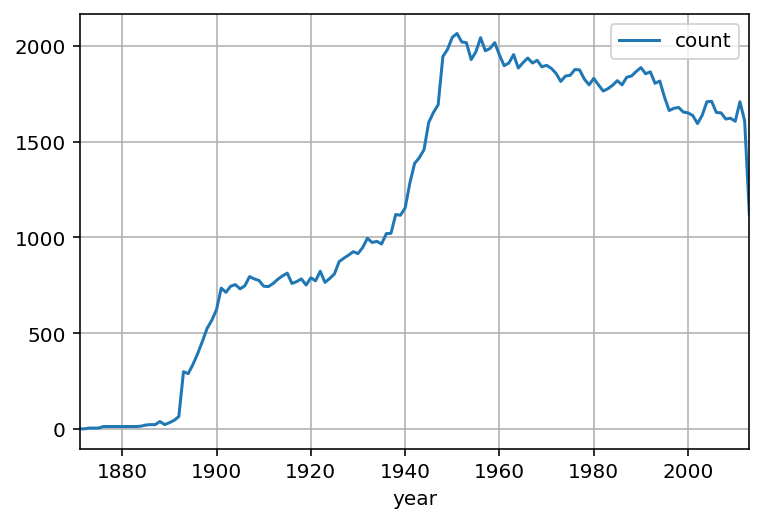

In [20]:
import pandas as pd    
A=counts.toPandas() # Transform a spark Dataframe to a Pandas Dataframe
A.plot.line('year','count')
grid()

### Reading rows selectively
Suppose we are only interested in snow measurements. We can apply an SQL query directly to the 
parquet files. As the data is organized in columnar structure, we can do the selection efficiently without loading the whole file to memory.

Here the file is small, but in real applications it can consist of hundreds of millions of records. In such cases loading the data first to memory and then filtering it is very wasteful.

In [21]:
data_dir='../../Data'
query="""SELECT station,measurement,year 
FROM parquet.`%s.parquet` 
WHERE measurement=\"SNOW\" """%(weather_dir+'/'+zip_file[:-4])
print(query)
df2 = sqlContext.sql(query)
print(df2.count(),df2.columns)
df2.show(5)

SELECT station,measurement,year 
FROM parquet.`/Users/brianroepke/Projects/UCSanDiegoX/Big-Data/Data/Weather/NY.parquet` 
WHERE measurement="SNOW" 
15629 ['station', 'measurement', 'year']
+-----------+-----------+----+
|    station|measurement|year|
+-----------+-----------+----+
|USC00308600|       SNOW|1932|
|USC00308600|       SNOW|1956|
|USC00308600|       SNOW|1957|
|USC00308600|       SNOW|1958|
|USC00308600|       SNOW|1959|
+-----------+-----------+----+
only showing top 5 rows



## Summary

* Dataframes can be manipulated decleratively, which allows for more optimization.
* Dataframes can be stored and retrieved from Parquet files.
* It is possible to refer directly to a parquet file in an SQL query.
* See you next time!

## References
* For an introduction to Spark SQL and Dataframes see: [Spark SQL, DataFrames](https://spark.apache.org/docs/latest/sql-programming-guide.html#spark-sql-dataframes-and-datasets-guide)
* Also [spark-dataframe-and-operations](https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/) from [analyticsvidhya.com](https://www.analyticsvidhya.com)

For complete API reference see
* [SQL programming guide](https://spark.apache.org/docs/latest/sql-programming-guide.html) For Java, Scala and Python (Implementation is first in Scala and Python, later pyspark)
* [pyspark API for the DataFrame class](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) 
* [pyspark API for the pyspark.sql module](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark-sql-module)
